<a href="https://colab.research.google.com/github/maticvl/dataHacker/blob/master/pyTorch/014_siameseNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

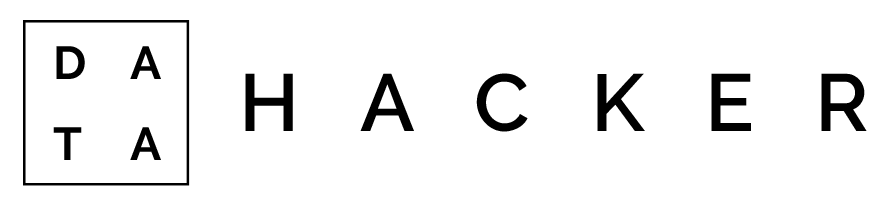
# Siamese Networks

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    
import os
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from sklearn.cluster import KMeans
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Datasets

In [3]:
dataset = 1
# Load the training dataset
if dataset == 1:
    folder_dataset = datasets.ImageFolder(root=r"D:\Uni_Sem4\SiameseNeuralNetwork\data\faces\training")
    folder_dataset_test = datasets.ImageFolder(root=r"D:\Uni_Sem4\SiameseNeuralNetwork\data\faces\testing/")
    # Resize the images and transform to tensors
    transformation = transforms.Compose([transforms.Resize((100,100)),
                                        transforms.ToTensor()
                                        ])
    no_epochs = 150
elif dataset == 2:
    folder_dataset = datasets.ImageFolder(root=r"D:\Uni_Sem4\SiameseNeuralNetwork\data\MNIST_Data\training")
    folder_dataset_test = datasets.ImageFolder(root=r"D:\Uni_Sem4\SiameseNeuralNetwork\data\MNIST_Data\testing")
    # Resize the images and transform to tensors
    transformation = transforms.Compose([transforms.Resize((24,24)),
                                        transforms.ToTensor()
                                        ])
    no_epochs = 150

In [4]:
# Creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [5]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None, rand=True):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.rand = rand
        self.labels = iter(np.unique([file[1] for file in self.imageFolderDataset.imgs]))
        self.current_label = next(self.labels)
        self.files = iter([file[0] for file in self.imageFolderDataset.imgs if file[1]==self.current_label])
    def __getitem__(self,index):
        if self.rand:
            anchor_tuple = random.choice(self.imageFolderDataset.imgs)
            while True:
                #Look untill the same class image is found
                positive_tuple = random.choice(self.imageFolderDataset.imgs) 
                if anchor_tuple[1] == positive_tuple[1]:
                    break


            while True:
                #Look untill a different class image is found
                negative_tuple = random.choice(self.imageFolderDataset.imgs) 
                if anchor_tuple[1] != negative_tuple[1]:
                    break
            anchor = Image.open(anchor_tuple[0])
            positive = Image.open(positive_tuple[0])
            negative = Image.open(negative_tuple[0])
            label = [anchor_tuple[0].split('\\')[-2]]
        else:
            try:
                self.current_file = next(self.files)
                while True:
                    #Look untill the same class image is found
                    positive_tuple = random.choice(self.imageFolderDataset.imgs) 
                    if self.current_label == positive_tuple[1]:
                        break


                while True:
                    #Look untill a different class image is found
                    negative_tuple = random.choice(self.imageFolderDataset.imgs) 
                    if self.current_label != negative_tuple[1]:
                        break
                anchor = Image.open(self.current_file)
                positive = Image.open(positive_tuple[0])
                negative = Image.open(negative_tuple[0])
                label = [self.current_file.split('\\')[-2]]
            except:
                self.current_label = next(self.labels)
                self.files = iter([file[0] for file in self.imageFolderDataset.imgs if file[1]==self.current_label])
                while True:
                    #Look untill the same class image is found
                    positive_tuple = random.choice(self.imageFolderDataset.imgs) 
                    if self.current_label == positive_tuple[1]:
                        break


                while True:
                    #Look untill a different class image is found
                    negative_tuple = random.choice(self.imageFolderDataset.imgs) 
                    if self.current_label != negative_tuple[1]:
                        break
                anchor = Image.open(self.current_file)
                positive = Image.open(positive_tuple[0])
                negative = Image.open(negative_tuple[0])
                label = [self.current_file.split('\\')[-2]]                

        anchor = anchor.convert("L")
        positive = positive.convert("L")
        negative = negative.convert("L")

        if self.transform is not None:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)
        
        
        return anchor, positive, negative, label
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)
    
    def get_current_value(self):
        if self.index >= len(self.iterable):
            raise StopIteration
        return self.iterable[self.index]

Download the dataset from our [GitHub](https://github.com/maticvl/dataHacker/blob/master/DATA/at%26t.zip) profile, just by running the code below.

In [6]:
#Download the dataset from our [GitHub](https://github.com/maticvl/dataHacker/blob/master/DATA/at%26t.zip) profile, just by running the code below.

In [7]:
# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

torch.Size([11, 1, 100, 100])


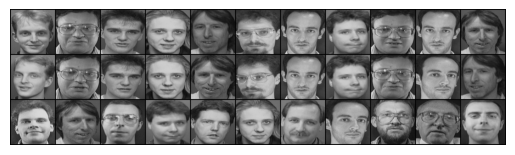

[('s40', 's31', 's30', 's12', 's39', 's17', 's16', 's23', 's31', 's16', 's39')]


In [8]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=11)

# Extract one batch
example_batch = next(iter(vis_dataloader))
print(example_batch[0].shape)
# Example batch is a list containing 3x11 images
concatenated = torch.cat((example_batch[0], example_batch[1], example_batch[2]),0)
imshow(torchvision.utils.make_grid(concatenated,nrow=11))
print(example_batch[3])


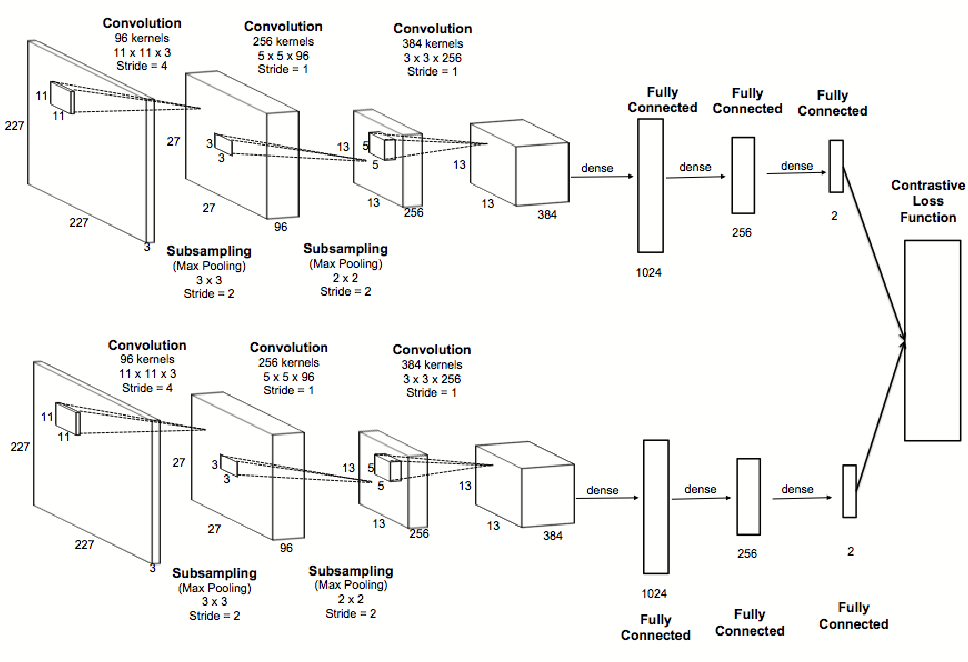

In [9]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()
        if dataset ==1:
            # Setting up the Sequential of CNN Layers
            self.cnn1 = nn.Sequential(
                nn.Conv2d(1, 96, kernel_size=11,stride=4),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(3, stride=2),
                
                nn.Conv2d(96, 256, kernel_size=5, stride=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, stride=2),

                nn.Conv2d(256, 384, kernel_size=3,stride=1),
                nn.ReLU(inplace=True)
            )

            # Setting up the Fully Connected Layers
            self.fc1 = nn.Sequential(
                nn.Linear(384, 1024),
                nn.ReLU(inplace=True),
                
                nn.Linear(1024, 256),
                nn.ReLU(inplace=True),
                
                nn.Linear(256,2)
            )
        elif dataset==2:
            # Setting up the Fully Connected Layers
            self.cnn1 = nn.Sequential(
                nn.Conv2d(1, 10, kernel_size=5),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(3, stride=2),
                
                nn.Conv2d(10, 20, kernel_size=5),
                nn.ReLU(inplace=True),
                nn.Flatten()

            )
            self.fc1 = nn.Sequential(
                nn.Linear(500, 1024),
                nn.ReLU(inplace=True),
                
                nn.Linear(1024, 256),
                nn.ReLU(inplace=True),
                
                nn.Linear(256,2)
            )
        
    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, anchor, positive, negative):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output_anchor = self.forward_once(anchor)
        output_positive = self.forward_once(positive)
        output_negative = self.forward_once(negative)

        return output_anchor, output_positive, output_negative

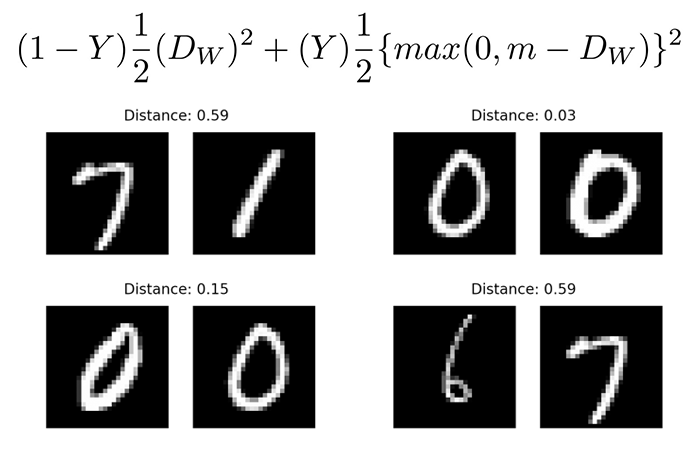

In [10]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [11]:
# Define the Triplet Loss Function
class TripletLoss(torch.nn.Module):
    def __init__(self, margin =2.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
    
    def forward(self, anchor, positive, negative):
        #Calculate the eucidian distance and calculate the Triplet Loss
        distance_positive = F.pairwise_distance(anchor, positive, keepdim=True)
        distance_negative = F.pairwise_distance(anchor, negative, keepdim=True)

        loss_triplet = torch.mean(F.relu(distance_positive - distance_negative + self.margin))

        return loss_triplet

In [12]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=64)

In [13]:
net = SiameseNetwork().to(device)
criterion = TripletLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

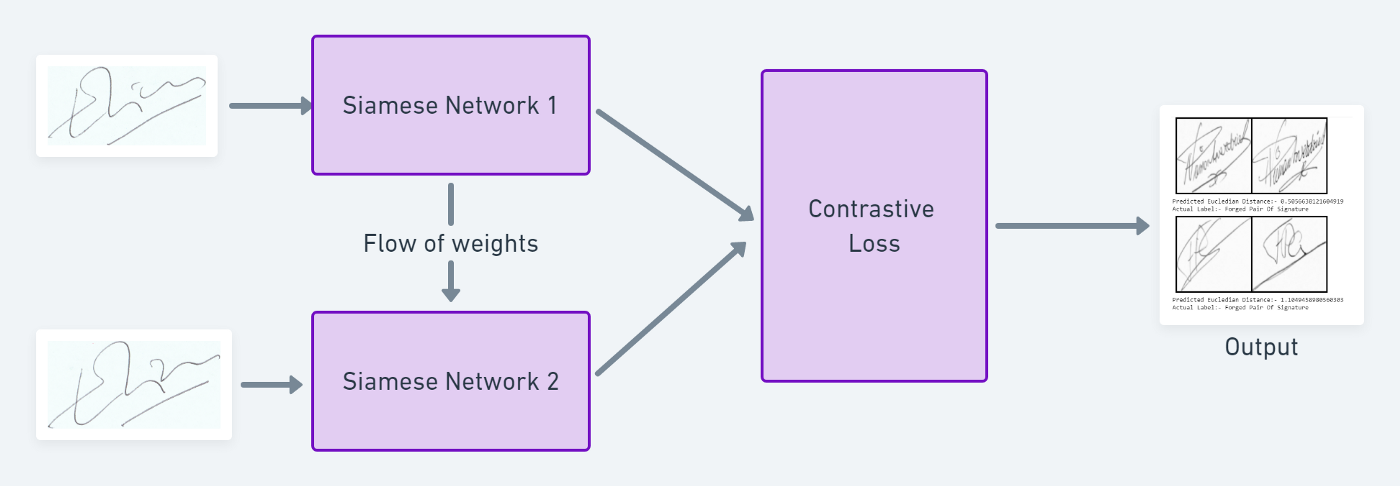

Epoch number 0
 Current loss 1.9993970394134521

Epoch number 1
 Current loss 1.5622668266296387

Epoch number 2
 Current loss 1.019859790802002

Epoch number 3
 Current loss 0.7411057949066162

Epoch number 4
 Current loss 0.7979359030723572

Epoch number 5
 Current loss 0.9754343032836914

Epoch number 6
 Current loss 0.40805768966674805

Epoch number 7
 Current loss 0.8675189018249512

Epoch number 8
 Current loss 0.46465227007865906

Epoch number 9
 Current loss 0.7475501298904419

Epoch number 10
 Current loss 0.6292848587036133

Epoch number 11
 Current loss 0.3148297369480133

Epoch number 12
 Current loss 0.5355647802352905

Epoch number 13
 Current loss 0.6928310394287109

Epoch number 14
 Current loss 0.5046789646148682

Epoch number 15
 Current loss 0.3048452138900757

Epoch number 16
 Current loss 0.4628426432609558

Epoch number 17
 Current loss 0.4770052433013916

Epoch number 18
 Current loss 0.36581453680992126

Epoch number 19
 Current loss 0.288981169462204

Epoch num

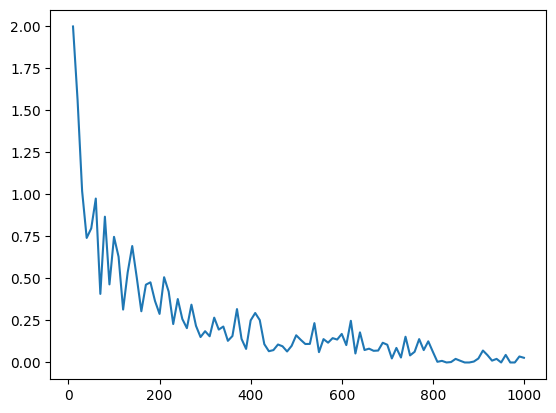

In [14]:
counter = []
loss_history = [] 
iteration_number= 0

# Iterate throught the epochs
for epoch in range(75):
    # Iterate over batches
    for i, (anchor, positive, negative, _) in enumerate(train_dataloader):
        # Send the images and labels to CUDA
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output_anchor, output_positive, output_negative = net(anchor, positive, negative)

        # Pass the outputs of the networks and label into the loss function
        loss_triplet = criterion(output_anchor, output_positive, output_negative)

        # Calculate the backpropagation
        loss_triplet.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_triplet.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_triplet.item())

show_plot(counter, loss_history)

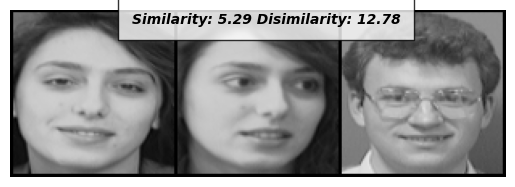

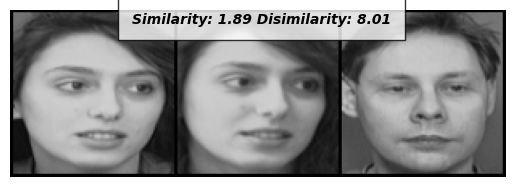

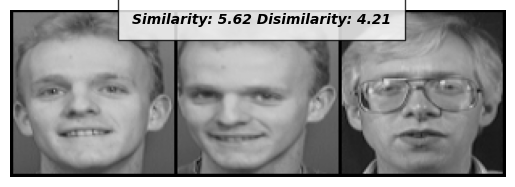

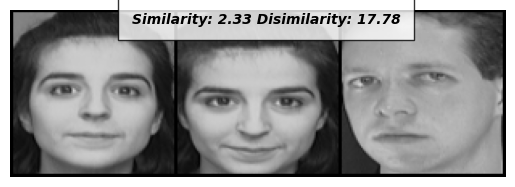

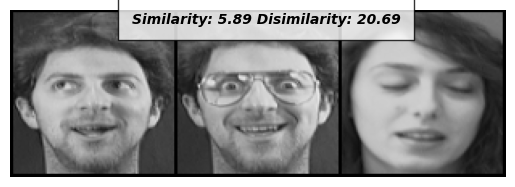

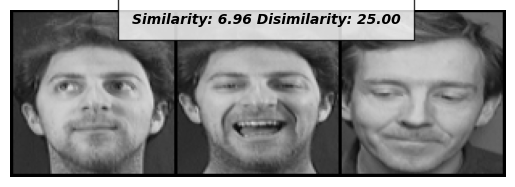

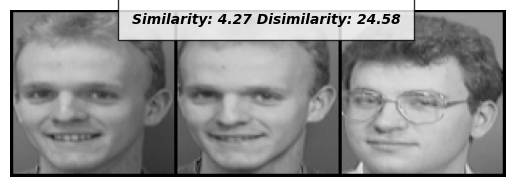

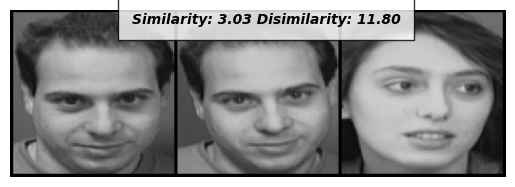

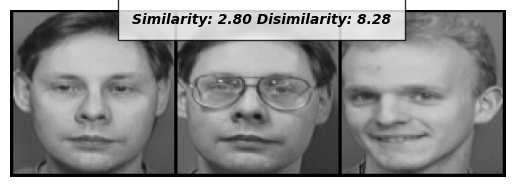

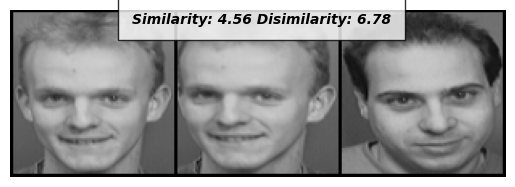

In [15]:
# Load it into the SiameseNetworkDataset

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
anchor, positive, negative, _ = next(dataiter)

for i in range(10):
    # Iterate over 10 images and test them with the first image (x0)
    anchor, positive, negative, _ = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((anchor, positive, negative), 0)
    
    output_anchor, output_positive, output_negative = net(anchor.to(device), positive.to(device), negative.to(device))
    euclidean_distance_positive = F.pairwise_distance(output_anchor, output_positive)
    euclidean_distance_negative = F.pairwise_distance(output_anchor, output_negative)
    imshow(torchvision.utils.make_grid(concatenated), f'Similarity: {euclidean_distance_positive.item():.2f} Disimilarity: {euclidean_distance_negative.item():.2f}')

Save Parameters


In [16]:
#torch.save({"model_state_dict": net.state_dict(),"optimizer_state_dict": optimizer.state_dict()}, "trained_model.pth")

Visualization of trained network

In [17]:
k_train = 5  # Adjust this according to your desired number of clusters
k_test = 5
train_results = []
labels = []
net.eval()
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation,rand=False)
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=11)

# Extract one batch
anchor, _, _, label = next(iter(vis_dataloader))

with torch.no_grad():
    for i in range(k_train):
        output_anchor = net.forward_once(anchor.to(device))
        train_results.append(output_anchor.cpu().numpy())
        labels.append(label[0])
        anchor, _, _, label = next(iter(vis_dataloader))

## test data
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation,rand=False)
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=11)

# Extract one batch
anchor, _, _, label = next(iter(vis_dataloader))

with torch.no_grad():
    for i in range(k_test):
        output_anchor = net.forward_once(anchor.to(device))
        train_results.append(output_anchor.cpu().numpy())
        labels.append(label[0])
        anchor, _, _, label = next(iter(vis_dataloader))


train_results = np.concatenate(train_results)
labels = np.concatenate(labels)
labels=np.array(labels)

combined_data = list(zip(train_results,labels))




*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

[  8.596459 -80.983284]
[1.29557   2.4724257]
[4.179883 6.227722]


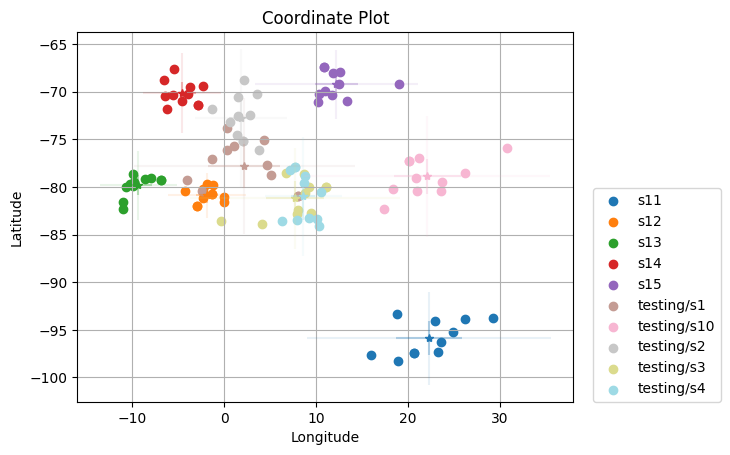

In [18]:
cmap = plt.cm.get_cmap('tab20', len(np.unique([point[1] for point in combined_data])))
fig, ax = plt.subplots()
for label in enumerate(np.unique([point[1] for point in combined_data])):
    points = [data[0] for data in combined_data if data[1]==label[1]]
    ax.scatter([point[0] for point in points], [point[1] for point in points], c=cmap(label[0]), label=label[1])
    points = np.concatenate(points)
    points=points.reshape(-1,2)
    group_means = np.mean(points,axis=0)
    group_std = np.std(points, axis=0)
    group_range = np.ptp(points, axis=0)
    # Plot the mean as a center point
    ax.plot(group_means[0], group_means[1],marker ="*", c=cmap(label[0]))

    # Plot the standard deviation as error bars
    ax.errorbar(group_means[0], group_means[1], xerr=group_std[0], yerr=group_std[1],
            fmt='none', ecolor=cmap(label[0]), alpha=0.3)

    # Plot the range as error bars
    ax.errorbar(group_means[0], group_means[1], xerr=group_range[0], yerr=group_range[1],
            fmt='none', ecolor=cmap(label[0]), alpha=0.1)

ax.grid(True)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Coordinate Plot')
plt.legend(loc=(1.04, 0))
plt.show()

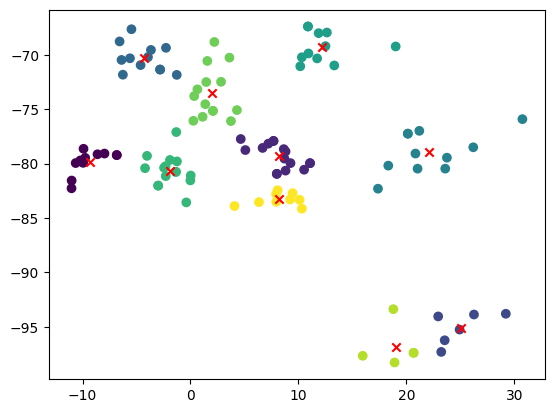

In [31]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=k_test+k_train)
kmeans.fit(train_results)

# Get the cluster labels and cluster centers
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Plot the data points with different colors for each cluster
plt.scatter(train_results[:, 0], train_results[:, 1], c=labels)
# Plot the cluster centers
plt.scatter(centers[:, 0], centers[:, 1], marker='x', color='red')
plt.show()